In [1]:
import pandas as pd             
import numpy as np 
import matplotlib.pyplot as plt   
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import mode
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.preprocessing import Imputer
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score

# Data Preprocessing

First we will do some data preprocessing to make the dataset ready for training. Indeed by reading through the example notebook and by further analysis. Some inconsitencies will be problematic durint the training of the random forest.

In [3]:
# Load dataset
df = pd.read_csv('CrowdstormingDataJuly1st.csv', index_col=0)
df.head(3)

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


The first step is to remove all the rows from which we can not infere the answer to the question asked. We need to find the skin color of the soccer player based on the other feature at our disposal. We will thus first take interest in the column '_rater1_' and '_rater2_'. By looking at the dataset we can directly see that some rows have no "rating" and won't be able to help use during the training: we don't have the output labels for the classifier. This is only a real problem when using supervised learning.

We only have rating for ~85% of the dataset also each sample is unique.

In [4]:
# Good news we always have either the two rating or none
sum(~(df.rater1.isnull() == df.rater2.isnull()))

0

In [5]:
data = df.dropna(subset=['rater1', 'rater2']).copy()
print('Total available', len(df))
print('Total with rating', len(data), "({}%)".format(round(len(data)*100/len(df),3)))
print('Number of sample with disagrement:', sum(~(data.rater1 == data.rater2)))

Total available 146028
Total with rating 124621 (85.34%)
Number of sample with disagrement: 28907


In [6]:
data['skin'] = data[['rater1', 'rater2']].max(axis=1)

We can also look at own many "real" unique sample we have. Indeed a player is most certainly present multiple times. As we can see most of the players have several entries.

Number of unique player 1572


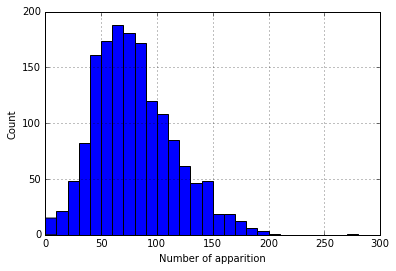

In [7]:
print("Number of unique player", len(data.player.unique()))
rows_per_player = data.player.value_counts()
ax = rows_per_player.hist(bins=28, range=(0, 280))
ax.set_xlabel('Number of apparition')
ax.set_ylabel('Count')

Next we will aggregate the data to only work with a sample per player. Some of the player are present only one time and other more than one hundred time.

Also a classifier as no notions of strings as input we thus need to deal with the columns with text features and encode them in a different way. We could either use a numbering encoding (clubX = 1, clubY = 2, etc) or juste dummy encode the column. We will use the dummy encoding.

We also deal with the missing data (_nan_ values).

##### Fill Nan values

Let's look at the missing values. We will have to deal with all of them before feeding anything to the classifier. As we can see some of the column have several missing values.

In [8]:
data.isnull().sum()

player              0
club                0
leagueCountry       0
birthday            0
height             46
weight            753
position         8461
games               0
victories           0
ties                0
defeats             0
goals               0
yellowCards         0
yellowReds          0
redCards            0
photoID             0
rater1              0
rater2              0
refNum              0
refCountry          0
Alpha_3             1
meanIAT           153
nIAT              153
seIAT             153
meanExp           153
nExp              153
seExp             153
skin                0
dtype: int64

In [9]:
# Height & Weight : Use mean
data['height'] = data['height'].fillna(data['height'].mean())
data['weight'] = data['weight'].fillna(data['weight'].mean())

# Position: add mew label
data['position'] = data['position'].fillna('UNKNOWN')

# We decided to drop all rows containging nan in the rest of the columns. Indeed it would be difficult to 
# decide by which value we need to fill the data as they are specific for each dyad player - referee
data.dropna(subset=['Alpha_3', 'meanIAT', 'nIAT','seIAT','meanExp','nExp','seExp'],axis=0, how='any', inplace=True)

##### Aggregation

We want to work only with information about player not dyad player-referee. We need to aggregate the unformation about each player into a single sample.

In [10]:
most_present = lambda x: x.value_counts().index[0]

players = data.groupby(level=0).agg({
    'leagueCountry': most_present,
    'position': most_present,
    'club': most_present,
    
    'height': 'mean', 
    'weight': 'mean',

    'meanIAT': 'mean',
    'nIAT': 'mean',
    'seIAT': 'mean',
    'meanExp': 'mean',
    'nExp': 'mean',
    'seExp': 'mean',

    'games':'sum',

    'victories':'sum',
    'defeats':'sum', 
    'ties': 'sum', 

    'goals':'mean',

    'redCards':'mean',
    'yellowReds': 'mean',
    'yellowCards':'mean',

    'skin': most_present
})

##### Skin color distribution


In [11]:
cm = plt.cm.get_cmap('RdYlBu_r')

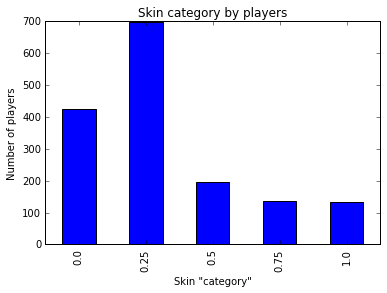

In [12]:
fig = players['skin'].value_counts(sort=False).sort_index().plot(kind='bar')
fig.set_ylabel('Number of players')
fig.set_xlabel('Skin "category"')
fig.set_title('Skin category by players')

---------------

##### Final preparation

The models can not work on text features such as the position and such. We will dummy encode them.

In [13]:
X = players.copy()
X.drop(['skin'], axis=1, inplace=True)
X = pd.get_dummies(X)

y = players.copy()['skin']


# Encoding label category
cat_encoding = preprocessing.LabelEncoder()
y = cat_encoding.fit_transform(y)

enc = preprocessing.OneHotEncoder()
enc.fit(X)

# Just create a struct like object
dataset = lambda:0
dataset.X = X
dataset.y = y

---------

# Exercise 1

# /!\ DISCLAIMER /!\
We chose to handle the problem as a multi class classification problem to stay closer to the original problem. It does mean that we are achieving a much lower accuracy but this comes from the fact that we have more class to choose from. And as the data is heavily skewed towards "white peopl"e, we used the `weighted f1 score` to compute the accuracy which is harsher than other accuracy measures when making errors on less represented classes.

We split our dataset into train and test. The model will be "defined/trained" using the train dataset and the model will be comprared on the classification based on the test set. We don't look at the test set until we do the comparision between different model.



In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, dataset.y, test_size=0.10)

### Baseline Model

First, we will define our baseline. We start by selecting randomly the skin color.

In [15]:
import warnings
warnings.filterwarnings('ignore')

y_random = np.random.randint(2, size=y_test.shape)
metrics.f1_score(y_test, y_random, average='weighted')

0.28117912930526012

By using the f1 score we can not fool anyone by just selecting the most present class.

In [16]:
most_present = mode(y_train)[0][0] # Model is definied based on train set
y_most = np.full(y_test.shape, most_present, dtype=int)
metrics.f1_score(y_test, y_most, average='weighted')

0.25622696921840804

### Random Forest

Now, let's try to developpe a classifier that will improve the accuracy.

In [17]:
def getRandomForestClassifier():
    n_estimators = 30
    max_depth = 15
    return RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=None, class_weight="balanced_subsample")

In [18]:
clf = getRandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
f1_score = metrics.f1_score(y_test, predictions, average='weighted')

print("Test set validation score:", f1_score)

Test set validation score: 0.430253741054


It seems that just going straight to the goal without much thinking is not going to work. We obtain just a bit of gain compared to selecting the most present class. Let's see where we are on the overfitting side.

In [19]:
accuracy_score(y_train, clf.predict(X_train))

0.98457223001402527

Well... We overfit _quite_ a bit.

In [20]:
import itertools

# See: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#see http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="f1_weighted")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



As we can see in the graph below, we predict mostly 0 or 1 (i.e. "white skin"). 

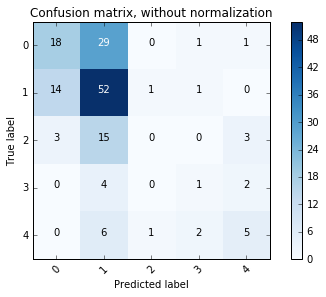

In [21]:
plt.figure()
conf_mat = metrics.confusion_matrix(y_test, predictions)
plot_confusion_matrix(conf_mat, classes=[0,1,2,3,4], title='Confusion matrix, without normalization')
plt.show()

Let's plot a learning curve to see if the size of the training set impacts the accuracy.

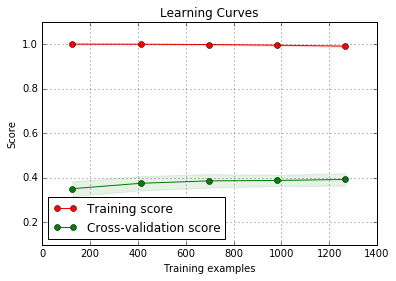

In [22]:
title = "Learning Curves"

cv = model_selection.ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = getRandomForestClassifier()
plot_learning_curve(estimator, title, dataset.X, dataset.y, ylim=(0.1, 1.1), cv=cv, n_jobs=4)

plt.show()

As we can see having a larger training set does not improve the accuracy. 
Maybe using a random forest is not the best approach as adding more data does not improve anything.

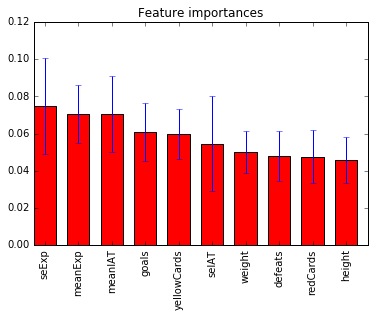

In [23]:
def plot_feature_importance(forest, X, y, columns, n_top=10):
    forest.fit(X, y)
    importances = forest.feature_importances_
    
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1][0:n_top]

    #indices = indices
    values = list(map(lambda x: importances[x], indices))
    stds = list(map(lambda x: std[x], indices))
    names = list(map(lambda x: columns[x], indices))
    
    y = values
    N = len(y)
    x = range(N)
    width = 1/1.5
    y_pos = np.arange(len(values))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(x, y, width, color="r", yerr=stds)
    plt.xticks(y_pos+width/2, names, rotation='vertical')
    plt.show()


    
plot_feature_importance(getRandomForestClassifier(), dataset.X, dataset.y, X.columns)


We can see that seExp, meanExp and meanIAT are the best features. These features depend on the referee of the dyad so aggregating them with a mean is not the best solution. By aggregating in a better way we could get a better score.

# Remove features to find widely different feature importances
Despite a lot of testing and tweaking, we were not able to find widely different feature importances.
When removing any feature(s) we could observe the same feature arrangement with the only difference being that the removed feature(s) were not in the list.

# Exercise 2

In [24]:
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics

In [25]:
# Function used to fit kmeans iterations time
# Returns the two scores (silhouette + accuracy)
def fit_kmeans_on_features(sets, data_in, data_out, iterations = 20):
    runs = []
    for feature_list in sets:
        if feature_list:
            results = []
            for _ in range(iterations):   
                feature_list = list(feature_list)
                X = preprocessing.scale(data_in[feature_list])
                kmeans = cluster.KMeans(n_clusters=2, init='k-means++', n_init=10)
                estimator = kmeans.fit(X)

                silhouette_score = metrics.silhouette_score(X, estimator.labels_)    
                
                # here we need to test both "skin color" set attribution. Indeed we can not know in advance if the set
                # corresponding to dark skin will be labeled 1 or 0 by kmeans.
                #accuracy = max(metrics.f1_score(data_out, estimator.labels_, average='weighted'), metrics.f1_score(~data_out, estimator.labels_, average='weighted'))
                accuracy = max(metrics.accuracy_score(data_out, estimator.labels_), metrics.accuracy_score(~data_out, estimator.labels_))

                results.append((silhouette_score, accuracy))

            runs.append((feature_list, results))
            
    return runs

We are asked to use unsupervised learning on the aggregated information about the referee for each player. The first step is thus to create a dataframe containing only the information we need. We also binarise the labels to be able to judge the "accuracy" of our clustering regarding the skin color.

This is how we understand the problem:
> We are given referee information about each player (one sample per player) without the skin color attribute. We then need to cluster the samples based on those feature. We then verify if the clustering reflect the skin color. I.E that the two clusters correspond each to one skin color (light / dark)

In [26]:
from itertools import chain, combinations

# Helper function to generate each combination of a set
def get_subsets(s):
    return chain(*map(lambda x: combinations(s, x), range(0, len(s)+1)))

The following referee information is at our disposal (cf. _data.md_):
    
- __refNum__ - unique referee ID number (referee name removed for anonymizing purposes)
- __refCountry__ - unique referee country ID number (country name removed for anonymizing purposes)
- __meanIAT__ - mean implicit bias score (using the race IAT) for referee country, higher values correspond to faster white | good, black | bad associations
- __nIAT__ - sample size for race IAT in that particular country
- __seIAT__ - standard error for mean estimate of race IAT
- __meanExp__ - mean explicit bias score (using a racial thermometer task) for referee country, higher values correspond to greater feelings of warmth toward whites versus blacks
- __nExp__ - sample size for explicit bias in that particular country
- __seExp__ - standard error for mean estimate of explicit bias measure

The data is given as dyad referee-player. Because we need to aggregate the referee information for each player such that we end up with only one sample per player. To start somewhere, we will first take the mean of the following attributes as aggregation technic.

- __meanIAT__ - mean implicit bias score (using the race IAT) for referee country, higher values correspond to faster white | good, black | bad associations
- __seIAT__ - standard error for mean estimate of race IAT
- __meanExp__ - mean explicit bias score (using a racial thermometer task) for referee country, higher values correspond to greater feelings of warmth toward whites versus blacks
- __seExp__ - standard error for mean estimate of explicit bias measure

Indeed, neither __refNum__ nor __refCountry__ can be aggregated. The sample size will be used afterwards to try to aggregate the values in a more intelligent way than just taking the means of the above values.

In [27]:
features = ['meanIAT', 'seIAT', 'seExp', 'meanExp', ]

data_clustering = data[features].groupby(level=0).mean()
data_clustering_skin = (data['skin'].groupby(level=0).mean() < 0.5).astype('bool')

Now it is time to find which feature enable the model to best cluster the data. To judge our model we will use to metrics. 
    
1. __Silhouette Score__: It is used to judge the quality of the clustering. More info can be found [here](https://en.wikipedia.org/wiki/Silhouette_(clustering).
    
2. __Accurarcy of the clustering regarding the skin color__. This will be used to judge the quality of the clustering regarding a clusering fully based on the skin color. 

The goal is thus to find the best f1_score and the best silhouette score. As we will see, there is a tradeoff between the two. 

Testing all combinations of the _features_ is time consuming but in our case were we keep only 4 attributes it is doable. 

Also, it is important to note that the kmeans is super senitive to the initial conditions. Indeed K-means starts with a random choice of cluster centers. So it may yield different clustering results every time we run the fit function. So to be sure we run multiple times the alorithm and average the result to get a better understanding of the feature set influence. 

In [28]:
sets = [f for f in get_subsets(features)][1:]
sets

[('meanIAT',),
 ('seIAT',),
 ('seExp',),
 ('meanExp',),
 ('meanIAT', 'seIAT'),
 ('meanIAT', 'seExp'),
 ('meanIAT', 'meanExp'),
 ('seIAT', 'seExp'),
 ('seIAT', 'meanExp'),
 ('seExp', 'meanExp'),
 ('meanIAT', 'seIAT', 'seExp'),
 ('meanIAT', 'seIAT', 'meanExp'),
 ('meanIAT', 'seExp', 'meanExp'),
 ('seIAT', 'seExp', 'meanExp'),
 ('meanIAT', 'seIAT', 'seExp', 'meanExp')]

In [29]:
runs_result = fit_kmeans_on_features(sets, data_clustering, data_clustering_skin)

Using some feature set, it is possible to obtain a "good" _silhouette score_ even though the _accuracy_ stays quiet low. It is most present when we use only one feature to cluster the data. Indeed by using only one feature it is possible to obtain a realy good clustering of the data (good _silhouette score_).

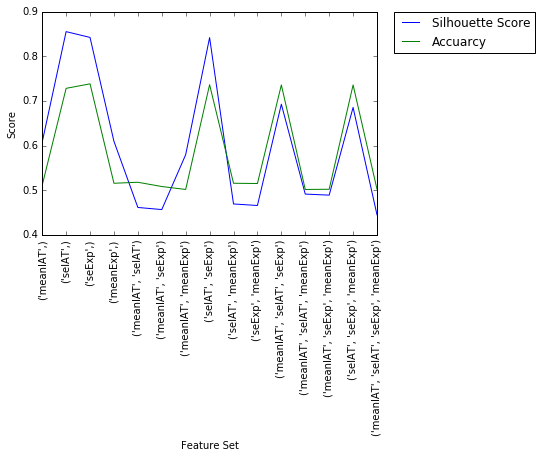

In [30]:
means = np.mean(np.array([v for f,v in runs_result]), axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
sil = ax.plot(means[:,0], label='Silhouette Score')
f1 = ax.plot(means[:,1], label='Accuarcy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

labels = sets
plt.xticks(range(15), labels, rotation='vertical')
ax.set_xlabel('Feature Set')
ax.set_ylabel('Score');

Let's now try to be smarter about the data at our disposal. Indeed above we aggregated by taking the mean for each feature. But this not take into account the relationship between the attributes. We will now try to combine those to
increase the clustering correctness.

In [31]:
player_group = data.groupby(level=0)
player = (data['skin'].groupby(level=0).mean() < 0.5).astype('int8')

#Recalculate the mean and std based on the number of samples for each players
def custom(g, name):
    m = sum(g['mean' + name]*g['n' + name])
    s = sum(g['se' + name]*g['n' + name])
    n = sum(g['n' + name])
    
    return pd.Series({"s" + name: s/n, "m"+name: m/n})

iat = player_group.apply(lambda x: custom(x,'IAT'))
exp = player_group.apply(lambda x: custom(x,'Exp'))

player_info = pd.concat([player,iat,exp], axis=1)

data_clustering = player_info
data_clustering_skin = (player_info['skin'].groupby(level=0).mean() > 0.5).astype('bool')

In [32]:
features = ['mIAT', 'sIAT', 'sExp', 'mExp', ]
sets = [f for f in get_subsets(features)][1:]
runs_result = fit_kmeans_on_features(sets, data_clustering, data_clustering_skin)

As we can see the recalculation of the features does not improves anything.

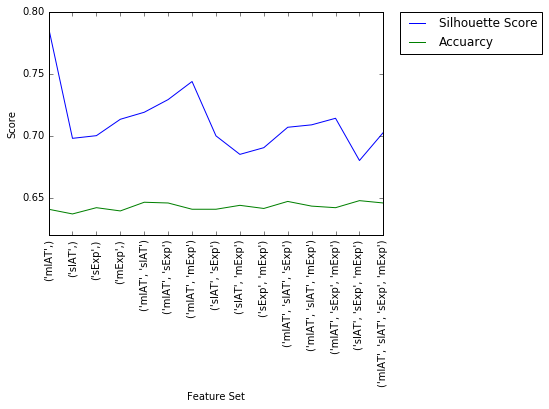

In [33]:
means = np.mean(np.array([v for f,v in runs_result]), axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
sil = ax.plot(means[:,0], label='Silhouette Score')
f1 = ax.plot(means[:,1], label='Accuarcy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

labels = sets
plt.xticks(range(15), labels, rotation='vertical')
ax.set_xlabel('Feature Set')
ax.set_ylabel('Score');

Now a question to be asked is are we really doing something useful. Especially is the accuarcy a good method to assess the quality of the clustering regarding the skin color. To do this we will just to the same run as before but instead of looking at the real "skin" distribution we will juste decide every body is black (or white).

In [34]:
features = ['meanIAT', 'seIAT', 'seExp', 'meanExp', ]

data_clustering = data[features].groupby(level=0).mean()
data_clustering_skin = (data['skin'].groupby(level=0).mean() < 0.5).astype('bool')
sets = [f for f in get_subsets(features)][1:]
runs_result = fit_kmeans_on_features(sets, data_clustering, np.ones(len(data_clustering)).astype('bool'))

As we can see, the accuracy is better now in some cases. 

We concluded (at least based on our few tries) that there is no easy way to find a clustering that match the skin color.

Also is important to note that we only tried kmean but we could also have used knn or any other machine learning algorithm that works on unsupervised learning.

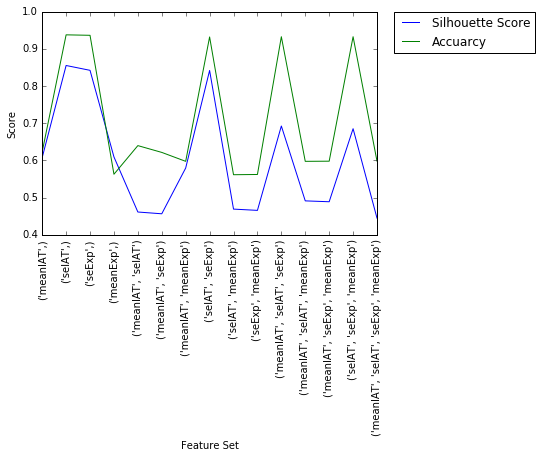

In [35]:
means = np.mean(np.array([v for f,v in runs_result]), axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
sil = ax.plot(means[:,0], label='Silhouette Score')
f1 = ax.plot(means[:,1], label='Accuarcy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

labels = sets
plt.xticks(range(15), labels, rotation='vertical')
ax.set_xlabel('Feature Set')
ax.set_ylabel('Score');